Ursprüngliche Quelle: https://blog.dominodatalab.com/fitting-gaussian-process-models-python/

Dieses Notebook verwendet einige Pakete, die nicht in der Python-Standardbibliothek enthalten sind. Unter der Annahme der Verwendung der [conda-Distribution](https://conda.io/miniconda.html) sollten folgende Befehle die Ausführung ermöglichen:

* `conda install numpy scipy matplotlib jupyter`
* `pip install ipydex`

# Mein bisheriges Verständnis von Gaußschen Prozessen ("Gaussian Processes")

Erkennnisreihenfolge:
* Gauß-Verteilung in einer Dimension (Schulwissen)
* Gauß-Verteilung in $n$ Dimensionen (Ingenieurwissen)
  * Bedeutung der Kovarianz-Matrix $\Sigma$ (Beschreibt, wie stark zufällige Werte miteinander korelliert sind)
  * Bestimmung der Verteilungsfunktion wenn ein Teil der Variablen ($y$) bekannt ist (= bedingte Wahrscheinlichkeit)



$$
\begin{equation}
%\label{eq_cond_distrib} % geht in jupyter-NB nicht
  p(x|y) = \mathcal{N}\Big(
  \underbrace{\mu_x + \Sigma_{xy} \Sigma_{y}^{-1}(y-\mu_x)}_{\mu_{\mathrm{bedingt}}},
  \overbrace{\Sigma_{x} - \Sigma_{xy} \Sigma_{y}^{-1} \Sigma_{xy}^T}^{\Sigma_\mathrm {bedingt}}\Big)
  \qquad \text{Achtung: ggf. verwirrende Variablenbezeichung $x$, $y$}
  \tag 1
\end{equation}
$$
  
* GP ist $n$-dimensionale Gaußverteilung mit Übergang $n \rightarrow \infty$.
  * Die Kovarianz-Matrix wäre dann unendlich groß. Sie wird durch eine Kernel-Funktion $k(p_i, p_j)$  ersetzt, welche die Korrelation zwischen den Punkten $p_i, p_j$ definiert. Für eine endliche Anzahl an Punkten $p_1, ... p_m$ bekommt man dann wieder eine endliche Kovarianzmatrix (Korrelation von jedem Punkt mit jedem Punkt.). Die Kernelfunktion $k(\cdot, \cdot)$ muss symmetrisch sein.
  
* Die konkrete Wahl der Kernel-Funktion legt die sog. apriori Verteilung fest (engl. "**prior**").
  * Ein sehr häufig angewendeter Kernel ist
  $$ k(p_1, p_2) = \theta_1  e^{\theta_2 |p_1 -p_2|^2}, $$
  meist als "quadratische Exponentialfunktion" bezeichnet, oder auch "Gaußsche Glockenkurve" (**daher kommt aber nicht der Name Gaußscher Prozess**)
  
* Für die Approximation der gesuchten Funktion $f$ auf Basis von gegebenen Daten ($(a_1, v1), (a_2, v_2), ..., (a_N, v_N)$ mit $v_i = f(a_i)$) wird
  1. ein "Prior" (bzw. eine apriori-Verteilung) gewählt (d.h. der Kernel wird festgelegt) und
  2. die bedingte Wahrscheinlichkeitsverteilung $p(\mathbf y|\mathbf v)$ von Funktionswerten $(y_1, ..., y_M)=:\mathbf y$ an den Auswertepunkten $(x_1, ..., x_M)=:\mathbf x$  bei gegebenen Daten $\mathbf v$ bestimmt (aposteriori-Verteilung, engl. "**posterior**").
* Die Argument-Werte $\mathbf a$ bzw $\mathbf x$ werden dabei zum Berechnen der neuen Mittelwertsfunktion $\mu_{\mathrm{bedingt}}$ und neuen Kovarianzmatrix $\Sigma_{\mathrm{bedingt}}$ benötigt, siehe $(1)$, denn sie sind in $\Sigma_{\mathbf a \mathbf a}, \Sigma_{\mathbf x \mathbf x}$ und $\Sigma_{\mathbf x \mathbf a}$ enthalten (die sich mit Hilfe von $k(\cdot, \cdot)$ berechnen lassen).

* Das Problem der unendlichen Dimension wird dadurch umgangen, dass der GP nur an endlich vielen Stellen (sagen wir $\lambda$) ausgewertet wird. Die Matrix $\Sigma_{\mathrm{bedingt}}$ hat dann die Dimensionen $\lambda \times \lambda$

* GP sind sog. parameterfreie Modelle. Sie müssen nicht "trainiert" werden. Die gegebenen Daten tragen selbst die Informationen.

* Es gibt aber **Meta-Parameter** der Kernel-Funktion (im Beispiel oben $\theta_1, \theta_2$). Diese kann man mit Hilfe eines Optimierungs-Algorithmus' bestimmen. Das kann man als "Training" auffassen.


---

Der folgende Quelltext stellt eine händische Implementierung zum besseren Verständnis dar. Für echte Anwendungen ist er nicht geeignet (zu langsam (pures Python), keine Metaparameter-Optimierung, ...)


  

In [1]:
%load_ext ipydex.displaytools

import numpy as np
import matplotlib.pyplot as plt

def exponential_cov(x, y, params):
    # für jede Kombination aus xi und yj wird die entsprechende Exponentialfunktion ausgewertet
    return params[0] * np.exp( -0.5 * 1/params[1]**2 * np.subtract.outer(x, y)**2)

Formel für bedingte Wahrscheinlichkeiten mehrvariabler Gauss-Verteilungen:

![alt text](https://blog.dominodatalab.com/wp-content/ql-cache/quicklatex.com-cef51da14fb0539b088d8c67d53d49c4_l3.png)

$$p(x|y) = \mathcal{N}\left(\mu_x + \Sigma_{xy} \Sigma_{y}^{-1}(y-\mu_y), \Sigma_{x} - \Sigma_{xy} \Sigma_{y}^{-1} \Sigma_{xy}^T\right)$$

In [2]:
def conditional(x_arg, y_arg, y_value, params):

    Sxx = exponential_cov(x_arg, x_arg, params)
    Sxy = exponential_cov(x_arg, y_arg, params)
    Syy = exponential_cov(y_arg, y_arg, params)
    

    # neuer Mittelwert
    mu = np.linalg.inv(Syy).dot(Sxy.T).T.dot(y)
    
    # neue Kovarianz -Matrix
    sigma = Sxx - Sxy.dot(np.linalg.inv(Syy).dot(Sxy.T))

    return(mu.squeeze(), sigma.squeeze())

sigma_0 := 1.0

---


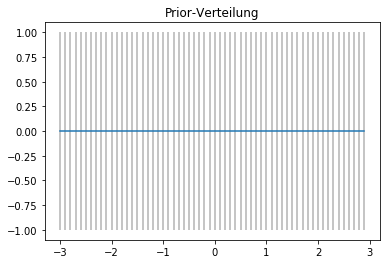

In [3]:
# Parameter des Kernels
theta = [1, 1]


sigma_0 = exponential_cov(0, 0, theta) ##:
xpts = np.arange(-3, 3, step=0.1)


# Mittelwert wird 0 gesetzt
mu_prior = xpts*0


# Prior-Verteilung darstellen (Mittelwert 0, Varianz sigma_0)
plt.errorbar(xpts, mu_prior, yerr=sigma_0, ecolor="0.7", capsize=0)
plt.title("Prior-Verteilung")
plt.show()

In [4]:
def predict(x, data_arg, kernel, metaparams, data_value, noise=0):
    """
    Function to predict y-value and cov-matrix Sigma at the argument values x
    given the data_values at the data_args
    
    
    x:           x-value where we want to predict
    data_arg:    x-values (arguments) for given data
    data_value:  y-values for given data
    noise:       standard deviation of gaussian noise for data (default: 0)
    """
    Syy = kernel(data_arg, data_arg, metaparams) + np.eye(data_arg.shape[0])*noise**2
    Sxy = kernel(x, data_arg, metaparams) # [kernel(x, da, params) for da in data_arg]
    Syyinv = np.linalg.inv(Syy)
    
    # new mean
    y_pred = np.dot(Sxy, Syyinv).dot(data_value)
    
    # new covariance matrix (Formula see above)
    sigma_new = kernel(x, x, metaparams) - np.dot(Sxy, Syyinv).dot(Sxy.T)
    
    return y_pred, sigma_new

In [5]:
# Gegebene Werte

data_args = np.array([1. , -1, 0])
data_values = np.array([.7, -.4, 1.1])



# Punkte, an denen der GP ausgewertet werden soll
x_pred = np.linspace(-3, 3, 300)


# Es gibt zwei verschiedene Berechnungsmöglichkeiten


# Mit einer Schleife für jedes argument einzeln (wie im Orignial-Blopost, Link siehe oben)
# eigentlich überflüssig
predictions = [predict(xarg, data_args, kernel=exponential_cov,
                       metaparams=theta,  data_value=data_values) for xarg in x_pred]


# vektoriell (einfacher, schneller)

mu_vector, K_matrix = predict(x_pred, data_args, data_value=data_values,
                              kernel=exponential_cov, metaparams=theta, noise=.1)

mu_vector.shape, K_matrix.shape

((300,), (300, 300))

Für gegebene bzw. gewählte Argument-Werte $z$ Kann man die neue Kovarianz-Matrix folgendermaßem berechnen (Hier jetzt inkl. $\sigma$-Term für Varianz der gegebenen Daten (Rauschen)):


$$\Sigma_{\mathrm{bedingt}}=K_{\mathrm{post}} = k (z, z) − k (z, u)^T(K + σn 2 I)^{-1}k(u, z) $$

Jetzt gilt: die zu $\mathbf z$ gehörenden Funktionswerte sind Normalverteilt mit Mittelwert $\mu_{\mathrm{bedingt}}$ und Kovarianz $\Sigma_{\mathrm{bedingt}}$: $\mathbf z \sim \mathcal N\left(\mu_{\mathrm{bedingt}}, \Sigma_{\mathrm{bedingt}}\right)$

Aus dieser Verteilung kann man jetzt z.B. mit `np.random.multivariate_normal` Realisierungen berechnen lassen.


In [6]:
N = 30

y_pred = mu_vector # Beste Schätzung für y: Mittelwert

samples = np.array([np.random.multivariate_normal(mu_vector, K_matrix) for i in range(N)])

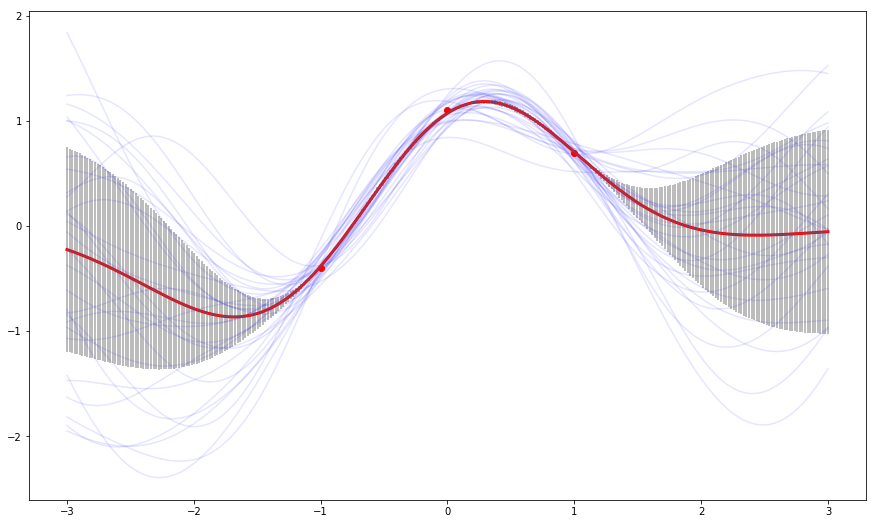

In [7]:
sigmas = np.diag(K_matrix)

plt.figure(figsize =(15, 9))

plt.errorbar(x_pred, y_pred, ecolor="0.3", yerr=sigmas, capsize=0, alpha=0.5)


# N Realisierungen (Samples) des Prozesses plotten
plt.plot(x_pred, samples.T, 'b-', alpha=0.1)


# Mittelwert-Funktion plotten
plt.plot(x_pred, y_pred, "red", lw=3)

# Originale Datenunkte plotten
plt.plot(data_args, data_values, "ro")
plt.show()

Aus der Grafik kann man folgendes ablesen:
* der Mittelwert geht durch die gegebenen Datenpunkte
* inder Nähe der gegebenen Datepunkte ist die Varianz sehr klein (wenn Rauschvarianz $\sigma$ klein gewählt wurde)
* Die einzelnen Realisierungen sehen aus wie glatte Funktionen (tatsächlich sind sie nur an bestimmten Stützstellen ausgewertet)
* je weiter man sich von den gegebenen Daten entfernt, um so mehr dominiert der Prior (hier: Mittelwert 0)



samples.shape  := (30, 300)

___


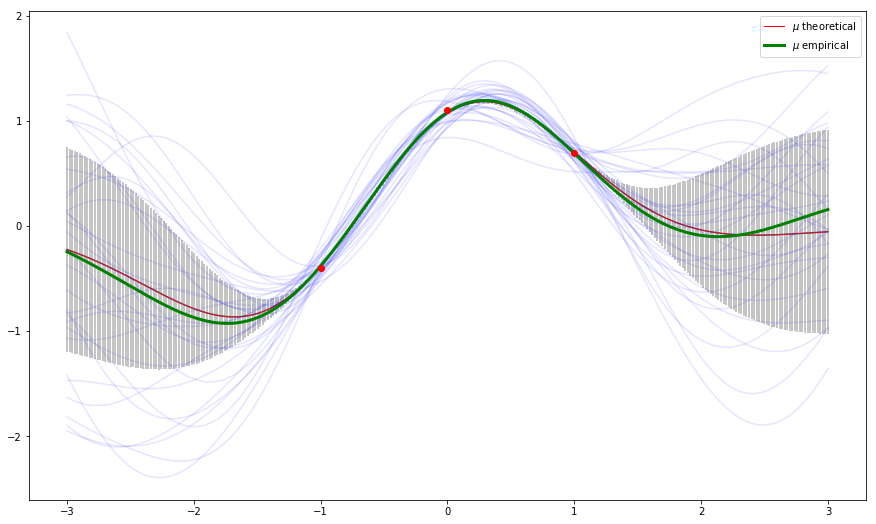

In [8]:
# Zum Vergleich: aus den Samples Mittelwert und Varianz empirisch berechnen und plotten


samples.shape ##:

mu_exp = np.mean(samples, axis=0)
s_exp = np.std(samples, axis=0)
var_exp=np.var(samples, axis=0)

plt.figure(figsize = (15, 9))

plt.errorbar(x_pred, y_pred, ecolor="0.7", yerr=sigmas, capsize=0, zorder=0)
plt.plot(x_pred, y_pred, "r-", lw=1, label="$\mu$ theoretical")

plt.plot(x_pred, samples.T, 'b-', alpha=0.1)

plt.plot(x_pred, mu_exp, 'g-', lw=3, label="$\mu$ empirical")

plt.plot(data_args, data_values, "ro")

plt.legend()
plt.show()

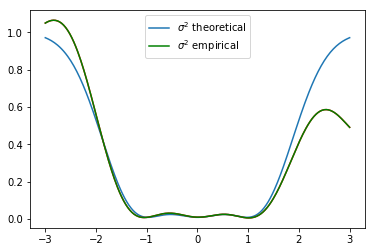

In [9]:
plt.plot(x_pred, sigmas, label="$\sigma^2$ theoretical")
plt.plot(x_pred, s_exp**2, 'r')
plt.plot(x_pred, var_exp, 'g', label="$\sigma^2$ empirical")

plt.legend()

#plt.plot(x_pred, np.diag(K_matrix) + .1)

plt.show()

Nächste Schritte:
* diese Ergebnisse mit einer Toolbox (z.B. `scikitlearn`) reproduzieren
* Das ganze auf Approximationen mehrdimensionaler Funktionen anwenden

---

## Toolbox `scikitlearn` verwenden um visuell ähnliche Ergebnisse zu erhalten:


In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

Problem: Veränderliche und z.T. schlechte Regressionsergebnisse (Optimierer für die Meta-Parameter findet oft untere Grenze (`length_scale_bounds`))

In [11]:
kernel = 1 * RBF(length_scale=10, length_scale_bounds=(1e-2, 1e3))

res_objects = []
res_parameters = []

for i in range(10):
    # GP-Objekt erstellen
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=3, random_state=i)
    
    # Optimierung der Meta-Parameter durchführen ("fit")
    gp.fit(data_args.reshape(-1, 1), data_values.reshape(-1, 1))
    d = gp.kernel_.get_params()
    
    res_objects.append(gp)
    res_parameters.append(d["k2__length_scale"])
    
    print(i, d["k1__constant_value"], d["k2__length_scale"])

0 0.620000003787 0.01
1 0.620000005776 0.0933847911947
2 0.617382080192 0.599591268736
3 0.620000071369 0.01
4 0.617382078433 0.599594919633
5 0.620000001919 0.01
6 0.617380493847 0.599589938676
7 0.617382847155 0.599590626838
8 0.617381381252 0.599591404331
9 0.620000002213 0.0466818055004


In [12]:
gp.kernel_.get_params()

{'k1': 0.787**2,
 'k1__constant_value': 0.62000000221268259,
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2': RBF(length_scale=0.0467),
 'k2__length_scale': 0.046681805500425277,
 'k2__length_scale_bounds': (0.01, 1000.0)}

In [13]:
# je ein gutes und ein schlechtes Ergebnis heraussuchen
# (Güte-Maß: Abstand zur unteren Schranke für Metaparameter)

index_bad = np.argmin(res_parameters)
index_good = np.argmax(res_parameters)

gp_bad = res_objects[index_bad]
gp_good = res_objects[index_good]

gp_good.score(data_args.reshape(-1, 1), data_values.reshape(-1, 1))  := 1.0

___


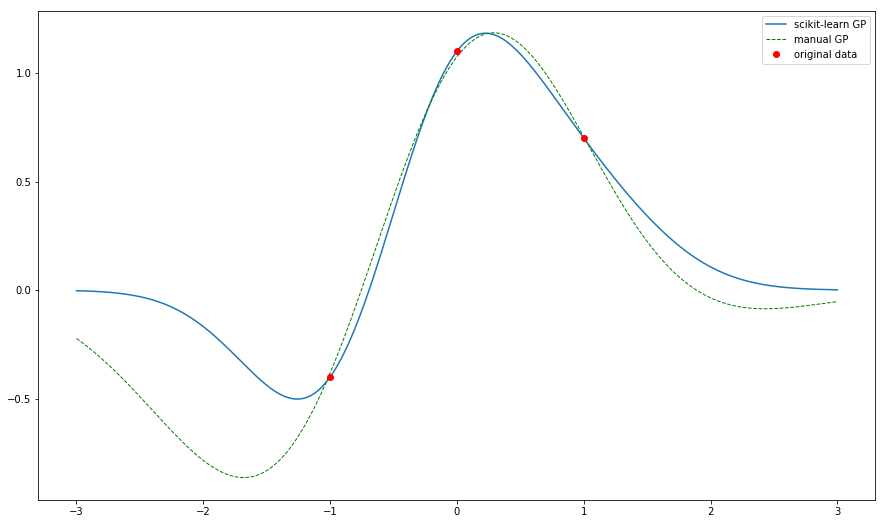

In [14]:
# Gutes Resultat plotten
m1, c1 = gp_good.predict(x_pred[:, np.newaxis], return_cov=True)
gp_good.score(data_args.reshape(-1, 1), data_values.reshape(-1, 1)) ##:

plt.figure(figsize = (15, 9))
plt.plot(x_pred, m1, label="scikit-learn GP")
plt.plot(x_pred, mu_vector, "g--", lw=1, label="manual GP")
plt.plot(data_args, data_values, "ro", label="original data")
plt.legend()

plt.show()


gp_bad.score(data_args.reshape(-1, 1), data_values.reshape(-1, 1))  := 1.0

___


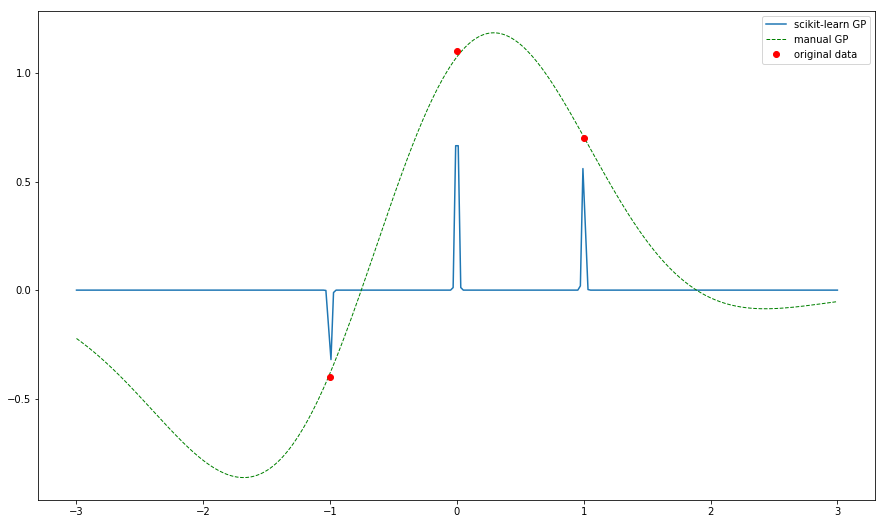

In [15]:
# Schlechtes Resultat plotten
m1, c1 = gp_bad.predict(x_pred[:, np.newaxis], return_cov=True)
gp_bad.score(data_args.reshape(-1, 1), data_values.reshape(-1, 1)) ##:


plt.figure(figsize = (15, 9))
plt.plot(x_pred, m1, label="scikit-learn GP")
plt.plot(x_pred, mu_vector, "g--", lw=1, label="manual GP")
plt.plot(data_args, data_values, "ro", label="original data")
plt.legend()

plt.show()

Achtung: dass die blaue Kurve nicht die Datenpunkte berührt ist ein Resultat mangelnder Auflösung von `x_pred`, denn auch bei `gp_bad` bekommt man einen `score` von 1.0. (= Perfekter Fit für die Trainingsdaten)

**Aber:** Dieses Beispiel zeigt, dass das "Optimierungsergebnis" für die Metaparameter unter Umständen alles andere als optimal ist.